# Phase 3: EfficientNetB5 Two-Phase Training (Based on Research Paper)

Approach from Paper: "A New Efficient Classifier for Bird Classification Based on Transfer Learning"

**Reference:** Mochurad & Svystovych (2024), Journal of Engineering

## 1. Setup & Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
from pathlib import Path

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('TensorFlow version:', tf.__version__)
print('✓ Imports successful!')

TensorFlow version: 2.19.0
✓ Imports successful!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Check GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [ ]:
# Configuration (adapted from paper)
NUM_CLASSES = 20

CLASS_NAMES = {
    0: 'Groove_billed_Ani', 1: 'Red_winged_Blackbird', 2: 'Rusty_Blackbird',
    3: 'Gray_Catbird', 4: 'Brandt_Cormorant', 5: 'Eastern_Towhee',
    6: 'Indigo_Bunting', 7: 'Brewer_Blackbird', 8: 'Painted_Bunting',
    9: 'Bobolink', 10: 'Lazuli_Bunting', 11: 'Yellow_headed_Blackbird',
    12: 'American_Crow', 13: 'Fish_Crow', 14: 'Brown_Creeper',
    15: 'Yellow_billed_Cuckoo', 16: 'Yellow_breasted_Chat',
    17: 'Black_billed_Cuckoo', 18: 'Gray_crowned_Rosy_Finch', 19: 'Bronzed_Cowbird'
}

CONFIG = {
    # Data paths
    'data_dir': '/content/drive/MyDrive/data',
    'train_csv': '/content/drive/MyDrive/data/train_metadata.csv',
    'val_csv': '/content/drive/MyDrive/data/val_metadata.csv',
    'train_images': '/content/drive/MyDrive/data/train_images',
    'val_images': '/content/drive/MyDrive/data/val_images',
    'test_images': '/content/drive/MyDrive/data/test_images/mistery_cat',
    'sample_submission': '/content/drive/MyDrive/data/sample_submission.csv',

    # Model params (from paper)
    'img_size': 224,  # Paper uses 224x224
    'batch_size': 32,  # Paper uses 32

    # Phase 1 training
    'phase1_epochs': 100,
    'phase1_lr': 0.001,  # Adam default
    'phase1_patience': 12,

    # Phase 2 training
    'phase2_epochs': 100,  # Max 100, paper trained 48
    'phase2_lr': 1e-5,  # Paper uses 1e-5
    'phase2_patience': 13,
    'phase2_layers_to_unfreeze': 35,  # Paper unfreezes last 92 layers

    # Model architecture (from paper)
    'dropout_rates': [0.4, 0.3, 0.2],
    'dense_units': [1024, 512, 256],

    # Output
    'checkpoint_dir': '/content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints',
    'results_dir': '/content/drive/MyDrive/ml_results/phase3_efficientnetb5_results',
}

os.makedirs(CONFIG['checkpoint_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)

print('✓ Configuration loaded (based on research paper)')
print(f"Image size: {CONFIG['img_size']}x{CONFIG['img_size']}")
print(f"Phase 1 epochs: {CONFIG['phase1_epochs']}")
print(f"Phase 2 epochs: {CONFIG['phase2_epochs']}")
print(f"Layers to unfreeze in Phase 2: {CONFIG['phase2_layers_to_unfreeze']}")

✓ Configuration loaded (based on research paper)
Image size: 224x224
Phase 1 epochs: 100
Phase 2 epochs: 100
Layers to unfreeze in Phase 2: 35


## 2. Data Augmentation (Exactly as in Paper)

In [ ]:
# Data augmentation from paper
# They use: RandomFlip, RandomTranslation, RandomRotation, RandomZoom, RandomContrast

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.05, 0.05, fill_mode="nearest"),
    layers.RandomRotation(0.05, fill_mode="nearest"),  # ±18 degrees
    layers.RandomZoom(0.05, fill_mode="nearest"),
    layers.RandomContrast(0.2),
], name='data_augmentation')

print('✓ Data augmentation pipeline created (from paper)')
print('  - RandomFlip (horizontal)')
print('  - RandomTranslation (±5%)')
print('  - RandomRotation (±18°)')
print('  - RandomZoom (±5%)')
print('  - RandomContrast (0.8-1.2)')

✓ Data augmentation pipeline created (from paper)
  - RandomFlip (horizontal)
  - RandomTranslation (±5%)
  - RandomRotation (±18°)
  - RandomZoom (±5%)
  - RandomContrast (0.8-1.2)


## 3. Data Loading

In [ ]:
# Load metadata
train_df = pd.read_csv(CONFIG['train_csv'])
val_df = pd.read_csv(CONFIG['val_csv'])

print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")
print(f"\nClass distribution:")
print(train_df['class_idx'].value_counts().sort_index())

Training images: 1082
Validation images: 103

Class distribution:
class_idx
0     58
1     53
2     57
3     54
4     53
5     54
6     57
7     55
8     52
9     58
10    54
11    54
12    53
13    54
14    52
15    55
16    51
17    55
18    51
19    52
Name: count, dtype: int64


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

def create_dataset(df, img_dir, is_training=True):
    """
    Create TensorFlow dataset with preprocessing
    """
    def load_and_preprocess(path, label):
        # Load image
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        # Resize to 224x224 (as in paper)
        img = tf.image.resize(img, [CONFIG['img_size'], CONFIG['img_size']])
        img = preprocess_input(img)
        return img, label

    # Create file paths and labels
    file_paths = [os.path.join(img_dir, path) for path in df['path'].values]
    labels = df['class_idx'].values

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if is_training:
        dataset = dataset.shuffle(1000)
        dataset = dataset.batch(CONFIG['batch_size'])
        # Prefetch for performance (as in paper)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(CONFIG['batch_size'])
        dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets
train_dataset = create_dataset(train_df, CONFIG['train_images'], is_training=True)
val_dataset = create_dataset(val_df, CONFIG['val_images'], is_training=False)

print('✓ TensorFlow datasets created')
print(f"Training batches: {len(list(train_dataset))}")
print(f"Validation batches: {len(list(val_dataset))}")

✓ TensorFlow datasets created
Training batches: 34
Validation batches: 4


## 4. Build Model (Exact Architecture from Paper)

In [ ]:
def build_model():
    # Helper for Squeeze-and-Excitation (Attention)
    def squeeze_excite_block(tensor, ratio=16):
        init = tensor
        filters = init.shape[-1]
        se_shape = (1, 1, filters)

        se = layers.GlobalAveragePooling2D()(init)
        se = layers.Reshape(se_shape)(se)
        se = layers.Dense(filters // ratio, activation='relu', use_bias=False)(se)
        se = layers.Dense(filters, activation='sigmoid', use_bias=False)(se)

        return layers.multiply([init, se])

    # 1. Input layer
    inputs = layers.Input(shape=(CONFIG['img_size'], CONFIG['img_size'], 3))
    x = data_augmentation(inputs)

    # 2. Base Pretrained Model
    # Important: Remove 'pooling' from EfficientNetB5 call to use custom attention
    base_model = EfficientNetB5(
        input_shape=(CONFIG['img_size'], CONFIG['img_size'], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False
    x = base_model(x, training=False)

    # 3. Custom Attention Layer (Squeeze-and-Excitation)
    x = squeeze_excite_block(x)
    x = layers.GlobalMaxPooling2D()(x) # Now pool after attention

    # 4. Dense Head (Paper architecture)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # 5. Output for 20 classes
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inputs, outputs), base_model

model, base_model = build_model()

print('✓ Model built (exact architecture from paper)')
print(f"\nTotal layers: {len(model.layers)}")
print(f"EfficientNetB5 layers: {len(base_model.layers)}")
print(f"\nModel summary:")
model.summary()

✓ Model built (exact architecture from paper)

Total layers: 19
EfficientNetB5 layers: 577

Model summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb5      │ (None, 7, 7,      │ 28,513,527 │ data_augmentatio… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ efficientnetb5[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 128) │    262,144 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1, 1,      │    262,144 │ dense_4[0][0]     │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ efficientnetb5[0… │
│                     │ 2048)             │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ multiply[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │  2,098,176 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1024)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │    131,328 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 20)        │      5,140 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 31,804,427 (121.32 MB)

 Trainable params: 3,287,316 (12.54 MB)

 Non-trainable params: 28,517,111 (108.78 MB)

## 5. PHASE 1: Train Top Layers Only

In [ ]:
# Compile model for Phase 1 (as in paper)

# Custom Loss for Label Smoothing with Sparse labels
def sparse_label_smoothed_loss(y_true, y_pred):
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), NUM_CLASSES)
    return keras.losses.categorical_crossentropy(
        y_true_one_hot, y_pred, label_smoothing=0.1 # Relaxes confidence
    )

# Use this inside your compile call
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['phase1_lr']),
    loss=sparse_label_smoothed_loss,
    metrics=['accuracy']
)

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=CONFIG['phase1_lr']),
#     loss='sparse_categorical_crossentropy',  # As in paper
#     metrics=['accuracy']
# )

# Callbacks (as in paper)
phase1_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['phase1_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        os.path.join(CONFIG['checkpoint_dir'], 'model_phase1.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
]

print('✓ Model compiled for Phase 1')
print(f"Optimizer: Adam (lr={CONFIG['phase1_lr']})")
print(f"Loss: Sparse Categorical Crossentropy")
print(f"Base model frozen: {not base_model.trainable}")

✓ Model compiled for Phase 1
Optimizer: Adam (lr=0.001)
Loss: Sparse Categorical Crossentropy
Base model frozen: True


In [ ]:
print("\n" + "="*70)
print("PHASE 1: TRAINING TOP LAYERS ONLY")
print("Base model frozen, training only added layers")
print("="*70 + "\n")

# Train Phase 1
history_phase1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIG['phase1_epochs'],
    callbacks=phase1_callbacks,
    verbose=1
)

print("\n✓ Phase 1 training complete!")


PHASE 1: TRAINING TOP LAYERS ONLY
Base model frozen, training only added layers

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2907 - loss: 2.8060
Epoch 1: val_loss improved from inf to 4.10916, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 43s 497ms/step - accuracy: 0.2939 - loss: 2.7932 - val_accuracy: 0.2427 - val_loss: 4.1092
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5526 - loss: 1.7878
Epoch 2: val_loss improved from 4.10916 to 2.11581, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - accuracy: 0.5536 - loss: 1.7861 - val_accuracy: 0.5146 - val_loss: 2.1158
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6688 - loss: 1.4887
Epoch 3: val_loss did not improve from 2.11581
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 0.6691 - loss: 1.4880 - val_accuracy: 0.5243 - val_loss: 2.3152
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7228 - loss: 1.3753
Epoch 4: val_loss improved from 2.11581 to 1.30693, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 260ms/step - accuracy: 0.7227 - loss: 1.3756 - val_accuracy: 0.7573 - val_loss: 1.3069
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7832 - loss: 1.2780
Epoch 5: val_loss improved from 1.30693 to 1.20931, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.7824 - loss: 1.2793 - val_accuracy: 0.8350 - val_loss: 1.2093
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8062 - loss: 1.1879
Epoch 6: val_loss improved from 1.20931 to 1.20262, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - accuracy: 0.8060 - loss: 1.1884 - val_accuracy: 0.7961 - val_loss: 1.2026
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8506 - loss: 1.1123
Epoch 7: val_loss did not improve from 1.20262
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8497 - loss: 1.1137 - val_accuracy: 0.8058 - val_loss: 1.2664
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8077 - loss: 1.1447
Epoch 8: val_loss did not improve from 1.20262
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8080 - loss: 1.1444 - val_accuracy: 0.8155 - val_loss: 1.2074
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8511 - loss: 1.0506
Epoch 9: val_loss improved from 1.20262 to 1.18441, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.8507 - loss: 1.0514 - val_accuracy: 0.8447 - val_loss: 1.1844
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8608 - loss: 1.0360
Epoch 10: val_loss did not improve from 1.18441
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8607 - loss: 1.0365 - val_accuracy: 0.8350 - val_loss: 1.1948
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8741 - loss: 1.0058
Epoch 11: val_loss improved from 1.18441 to 1.17594, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.8738 - loss: 1.0061 - val_accuracy: 0.8447 - val_loss: 1.1759
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8861 - loss: 0.9797
Epoch 12: val_loss did not improve from 1.17594
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.8859 - loss: 0.9802 - val_accuracy: 0.7864 - val_loss: 1.2680
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.8835 - loss: 0.9744
Epoch 13: val_loss improved from 1.17594 to 1.16510, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.8833 - loss: 0.9749 - val_accuracy: 0.8058 - val_loss: 1.1651
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9076 - loss: 0.9254
Epoch 14: val_loss did not improve from 1.16510
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9074 - loss: 0.9260 - val_accuracy: 0.7961 - val_loss: 1.2220
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9026 - loss: 0.9341
Epoch 15: val_loss did not improve from 1.16510
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9028 - loss: 0.9338 - val_accuracy: 0.8155 - val_loss: 1.1983
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9311 - loss: 0.8721
Epoch 16: val_loss improved from 1.16510 to 1.13376, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - accuracy: 0.9309 - loss: 0.8724 - val_accuracy: 0.8155 - val_loss: 1.1338
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9257 - loss: 0.8536
Epoch 17: val_loss did not improve from 1.13376
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9257 - loss: 0.8539 - val_accuracy: 0.8058 - val_loss: 1.1873
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9295 - loss: 0.8724
Epoch 18: val_loss did not improve from 1.13376
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9296 - loss: 0.8721 - val_accuracy: 0.8155 - val_loss: 1.1399
Epoch 19/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9331 - loss: 0.8583
Epoch 19: val_loss did not improve from 1.13376
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9328 - loss: 0.8589 - val_accuracy: 0.8544 - val_loss: 1.1614
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9422 - loss: 0.8369
Epoch 20: val_loss did not improve 

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9495 - loss: 0.8314 - val_accuracy: 0.8641 - val_loss: 1.1042
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9606 - loss: 0.7964
Epoch 23: val_loss did not improve from 1.10424
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9606 - loss: 0.7964 - val_accuracy: 0.8155 - val_loss: 1.1219
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9677 - loss: 0.7817
Epoch 24: val_loss did not improve from 1.10424
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9677 - loss: 0.7821 - val_accuracy: 0.8058 - val_loss: 1.1597
Epoch 25/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9435 - loss: 0.8098
Epoch 25: val_loss did not improve from 1.10424
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.9437 - loss: 0.8097 - val_accuracy: 0.7961 - val_loss: 1.2015
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9669 - loss: 0.7741
Epoch 26: val_loss did not improve 

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.9735 - loss: 0.7387 - val_accuracy: 0.8544 - val_loss: 1.0991
Epoch 34/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9703 - loss: 0.7410
Epoch 34: val_loss did not improve from 1.09913
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9705 - loss: 0.7406 - val_accuracy: 0.8447 - val_loss: 1.1278
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9862 - loss: 0.7058
Epoch 35: val_loss did not improve from 1.09913
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9863 - loss: 0.7059 - val_accuracy: 0.8252 - val_loss: 1.1462
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9881 - loss: 0.7166
Epoch 36: val_loss did not improve from 1.09913
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9880 - loss: 0.7168 - val_accuracy: 0.8447 - val_loss: 1.1028
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9864 - loss: 0.6998
Epoch 37: val_loss improved from 1.

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.9864 - loss: 0.6999 - val_accuracy: 0.8544 - val_loss: 1.0849
Epoch 38/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9957 - loss: 0.6913
Epoch 38: val_loss did not improve from 1.08487
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9956 - loss: 0.6915 - val_accuracy: 0.8641 - val_loss: 1.1244
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9898 - loss: 0.6995
Epoch 39: val_loss improved from 1.08487 to 1.04124, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.9896 - loss: 0.6999 - val_accuracy: 0.8447 - val_loss: 1.0412
Epoch 40/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9819 - loss: 0.7033
Epoch 40: val_loss did not improve from 1.04124
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9820 - loss: 0.7032 - val_accuracy: 0.8155 - val_loss: 1.0680
Epoch 41/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9872 - loss: 0.6981
Epoch 41: val_loss did not improve from 1.04124
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.9873 - loss: 0.6980 - val_accuracy: 0.8350 - val_loss: 1.0431
Epoch 42/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9876 - loss: 0.6982
Epoch 42: val_loss did not improve from 1.04124
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 0.9876 - loss: 0.6982 - val_accuracy: 0.8155 - val_loss: 1.1047
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9932 - loss: 0.6818
Epoch 43: val_loss improved from 1.0

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 264ms/step - accuracy: 0.9932 - loss: 0.6818 - val_accuracy: 0.8835 - val_loss: 1.0082
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9943 - loss: 0.6820
Epoch 44: val_loss improved from 1.00817 to 1.00401, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase1.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9943 - loss: 0.6820 - val_accuracy: 0.8544 - val_loss: 1.0040
Epoch 45/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9927 - loss: 0.6802
Epoch 45: val_loss did not improve from 1.00401
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - accuracy: 0.9927 - loss: 0.6802 - val_accuracy: 0.8447 - val_loss: 1.0104
Epoch 46/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9974 - loss: 0.6740
Epoch 46: val_loss did not improve from 1.00401
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9974 - loss: 0.6740 - val_accuracy: 0.8835 - val_loss: 1.0054
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9944 - loss: 0.6627
Epoch 47: val_loss did not improve from 1.00401
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9945 - loss: 0.6628 - val_accuracy: 0.8738 - val_loss: 1.0315
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9973 - loss: 0.6650
Epoch 48: val_loss did not improve f

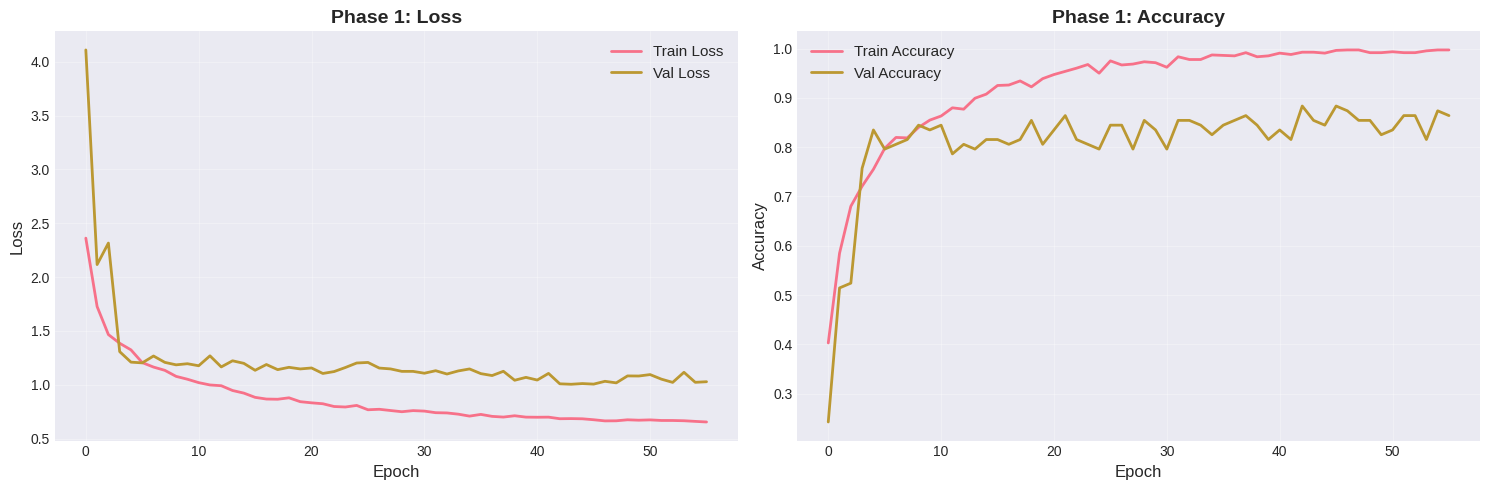


Phase 1 Best Results:
  Val Accuracy: 0.8835
  Val Loss: 1.0040


In [ ]:
# Plot Phase 1 results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_phase1.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_phase1.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Phase 1: Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_phase1.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_phase1.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Phase 1: Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase1_training.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print Phase 1 results
phase1_val_acc = max(history_phase1.history['val_accuracy'])
phase1_val_loss = min(history_phase1.history['val_loss'])

print(f"\nPhase 1 Best Results:")
print(f"  Val Accuracy: {phase1_val_acc:.4f}")
print(f"  Val Loss: {phase1_val_loss:.4f}")

## 6. PHASE 2: Fine-tune Last 92 Layers

In [ ]:
# Unfreeze last 92 layers (excluding BatchNormalization as in paper)
print("\n" + "="*70)
print("PHASE 2 PREPARATION: UNFREEZING LAYERS")
print("="*70)

base_model.trainable = True

# Count non-BatchNorm layers
non_bn_layers = [layer for layer in base_model.layers if 'batch_normalization' not in layer.name]
print(f"\nTotal base model layers: {len(base_model.layers)}")
print(f"Non-BatchNorm layers: {len(non_bn_layers)}")

# Freeze all except last 92 non-BatchNorm layers
layers_to_unfreeze = CONFIG['phase2_layers_to_unfreeze']
unfreeze_from_layer = len(non_bn_layers) - layers_to_unfreeze

print(f"\nUnfreezing last {layers_to_unfreeze} non-BatchNorm layers")
print(f"Starting from layer index: {unfreeze_from_layer}")

# Freeze/unfreeze logic
non_bn_idx = 0
for layer in base_model.layers:
    if 'batch_normalization' in layer.name:
        # Always freeze BatchNorm layers (as in paper)
        layer.trainable = False
    else:
        if non_bn_idx < unfreeze_from_layer:
            layer.trainable = False
        else:
            layer.trainable = True
        non_bn_idx += 1

# Count trainable params
trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in model.non_trainable_weights])

print(f"\n✓ Layer freezing complete")
print(f"Trainable parameters: {trainable_count:,}")
print(f"Non-trainable parameters: {non_trainable_count:,}")


PHASE 2 PREPARATION: UNFREEZING LAYERS

Total base model layers: 577
Non-BatchNorm layers: 577

Unfreezing last 35 non-BatchNorm layers
Starting from layer index: 542

✓ Layer freezing complete
Trainable parameters: 13,227,540
Non-trainable parameters: 18,576,887


In [ ]:
# Recompile model for Phase 2 (with lower learning rate)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['phase2_lr']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Phase 2 callbacks (with ReduceLROnPlateau as in paper)
phase2_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=CONFIG['phase2_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        os.path.join(CONFIG['checkpoint_dir'], 'model_phase2.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,  # Reduce by 5x (as in paper)
        patience=3,
        verbose=1,
        min_lr=1e-7
    )
]

print('\n✓ Model recompiled for Phase 2')
print(f"Optimizer: Adam (lr={CONFIG['phase2_lr']})")
print(f"ReduceLROnPlateau: factor=0.2, patience=3")


✓ Model recompiled for Phase 2
Optimizer: Adam (lr=1e-05)
ReduceLROnPlateau: factor=0.2, patience=3


In [ ]:
print("\n" + "="*70)
print("PHASE 2: FINE-TUNING LAST 92 LAYERS")
print("Lower learning rate, unfrozen layers will adapt to bird classification")
print("="*70 + "\n")

# Train Phase 2
history_phase2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=CONFIG['phase2_epochs'],
    callbacks=phase2_callbacks,
    verbose=1
)

print("\n✓ Phase 2 training complete!")


PHASE 2: FINE-TUNING LAST 92 LAYERS
Lower learning rate, unfrozen layers will adapt to bird classification

Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9765 - loss: 0.2275
Epoch 1: val_loss improved from inf to 0.48539, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 49s 538ms/step - accuracy: 0.9764 - loss: 0.2277 - val_accuracy: 0.8738 - val_loss: 0.4854 - learning_rate: 1.0000e-05
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9736 - loss: 0.2065
Epoch 2: val_loss improved from 0.48539 to 0.47284, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9736 - loss: 0.2065 - val_accuracy: 0.8641 - val_loss: 0.4728 - learning_rate: 1.0000e-05
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9815 - loss: 0.1977
Epoch 3: val_loss improved from 0.47284 to 0.46342, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.9815 - loss: 0.1975 - val_accuracy: 0.8835 - val_loss: 0.4634 - learning_rate: 1.0000e-05
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9819 - loss: 0.1881
Epoch 4: val_loss improved from 0.46342 to 0.45402, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9820 - loss: 0.1878 - val_accuracy: 0.8738 - val_loss: 0.4540 - learning_rate: 1.0000e-05
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9934 - loss: 0.1513
Epoch 5: val_loss improved from 0.45402 to 0.44771, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - accuracy: 0.9933 - loss: 0.1514 - val_accuracy: 0.8738 - val_loss: 0.4477 - learning_rate: 1.0000e-05
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9877 - loss: 0.1587
Epoch 6: val_loss improved from 0.44771 to 0.44109, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.9877 - loss: 0.1587 - val_accuracy: 0.8738 - val_loss: 0.4411 - learning_rate: 1.0000e-05
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9867 - loss: 0.1563
Epoch 7: val_loss improved from 0.44109 to 0.43868, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 12s 295ms/step - accuracy: 0.9867 - loss: 0.1562 - val_accuracy: 0.8835 - val_loss: 0.4387 - learning_rate: 1.0000e-05
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9841 - loss: 0.1320
Epoch 8: val_loss improved from 0.43868 to 0.43822, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9841 - loss: 0.1322 - val_accuracy: 0.8738 - val_loss: 0.4382 - learning_rate: 1.0000e-05
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9938 - loss: 0.1204
Epoch 9: val_loss improved from 0.43822 to 0.43393, saving model to /content/drive/MyDrive/ml_results/phase3_efficientnetb5_checkpoints/model_phase2.h5


34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.9938 - loss: 0.1207 - val_accuracy: 0.8641 - val_loss: 0.4339 - learning_rate: 1.0000e-05
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9966 - loss: 0.1144
Epoch 10: val_loss did not improve from 0.43393
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9966 - loss: 0.1144 - val_accuracy: 0.8738 - val_loss: 0.4342 - learning_rate: 1.0000e-05
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9930 - loss: 0.1241
Epoch 11: val_loss did not improve from 0.43393
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.9930 - loss: 0.1241 - val_accuracy: 0.8738 - val_loss: 0.4390 - learning_rate: 1.0000e-05
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9946 - loss: 0.1109
Epoch 12: val_loss did not improve from 0.43393

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - accuracy: 0.9946 - loss: 0.1109 -

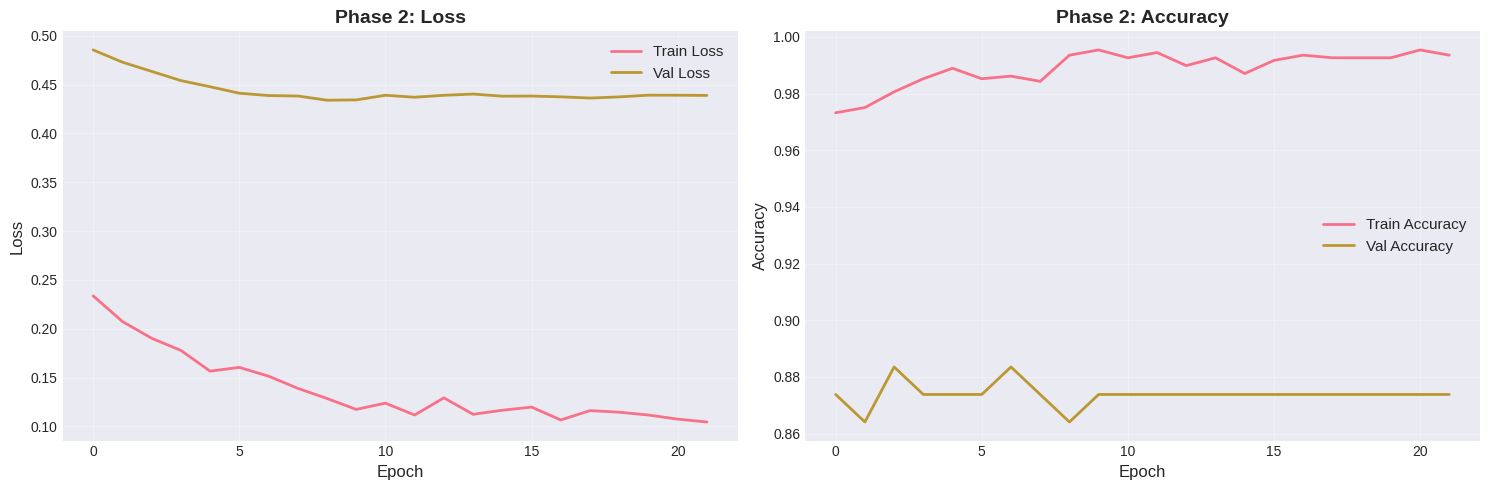


Phase 2 Best Results:
  Val Accuracy: 0.8835
  Val Loss: 0.4339

Improvement from Phase 1:
  Accuracy: +0.00%
  Loss: -0.5701


In [ ]:
# Plot Phase 2 results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history_phase2.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history_phase2.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Phase 2: Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_phase2.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history_phase2.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Phase 2: Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'phase2_training.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print Phase 2 results
phase2_val_acc = max(history_phase2.history['val_accuracy'])
phase2_val_loss = min(history_phase2.history['val_loss'])

print(f"\nPhase 2 Best Results:")
print(f"  Val Accuracy: {phase2_val_acc:.4f}")
print(f"  Val Loss: {phase2_val_loss:.4f}")

print(f"\nImprovement from Phase 1:")
print(f"  Accuracy: +{(phase2_val_acc - phase1_val_acc)*100:.2f}%")
print(f"  Loss: {phase2_val_loss - phase1_val_loss:.4f}")

## 7. Evaluation & Metrics (As in Paper)

In [ ]:
# Evaluate on validation set
print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

# Get predictions
all_preds = []
all_labels = []

for images, labels in tqdm(val_dataset, desc="Evaluating"):
    preds = model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    all_preds.extend(pred_classes)
    all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics (as in paper)
test_accuracy = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted')
test_recall = recall_score(all_labels, all_preds, average='weighted')
test_f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"\n📊 Final Metrics (Paper Format):")
print(f"  Accuracy:  {test_accuracy:.4f} (Paper: 0.9886 for 525 species)")
print(f"  Precision: {test_precision:.4f} (Paper: 0.99)")
print(f"  Recall:    {test_recall:.4f} (Paper: 0.99)")
print(f"  F1 Score:  {test_f1:.4f} (Paper: 0.99)")


FINAL EVALUATION


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]


📊 Final Metrics (Paper Format):
  Accuracy:  0.8641 (Paper: 0.9886 for 525 species)
  Precision: 0.8806 (Paper: 0.99)
  Recall:    0.8641 (Paper: 0.99)
  F1 Score:  0.8616 (Paper: 0.99)


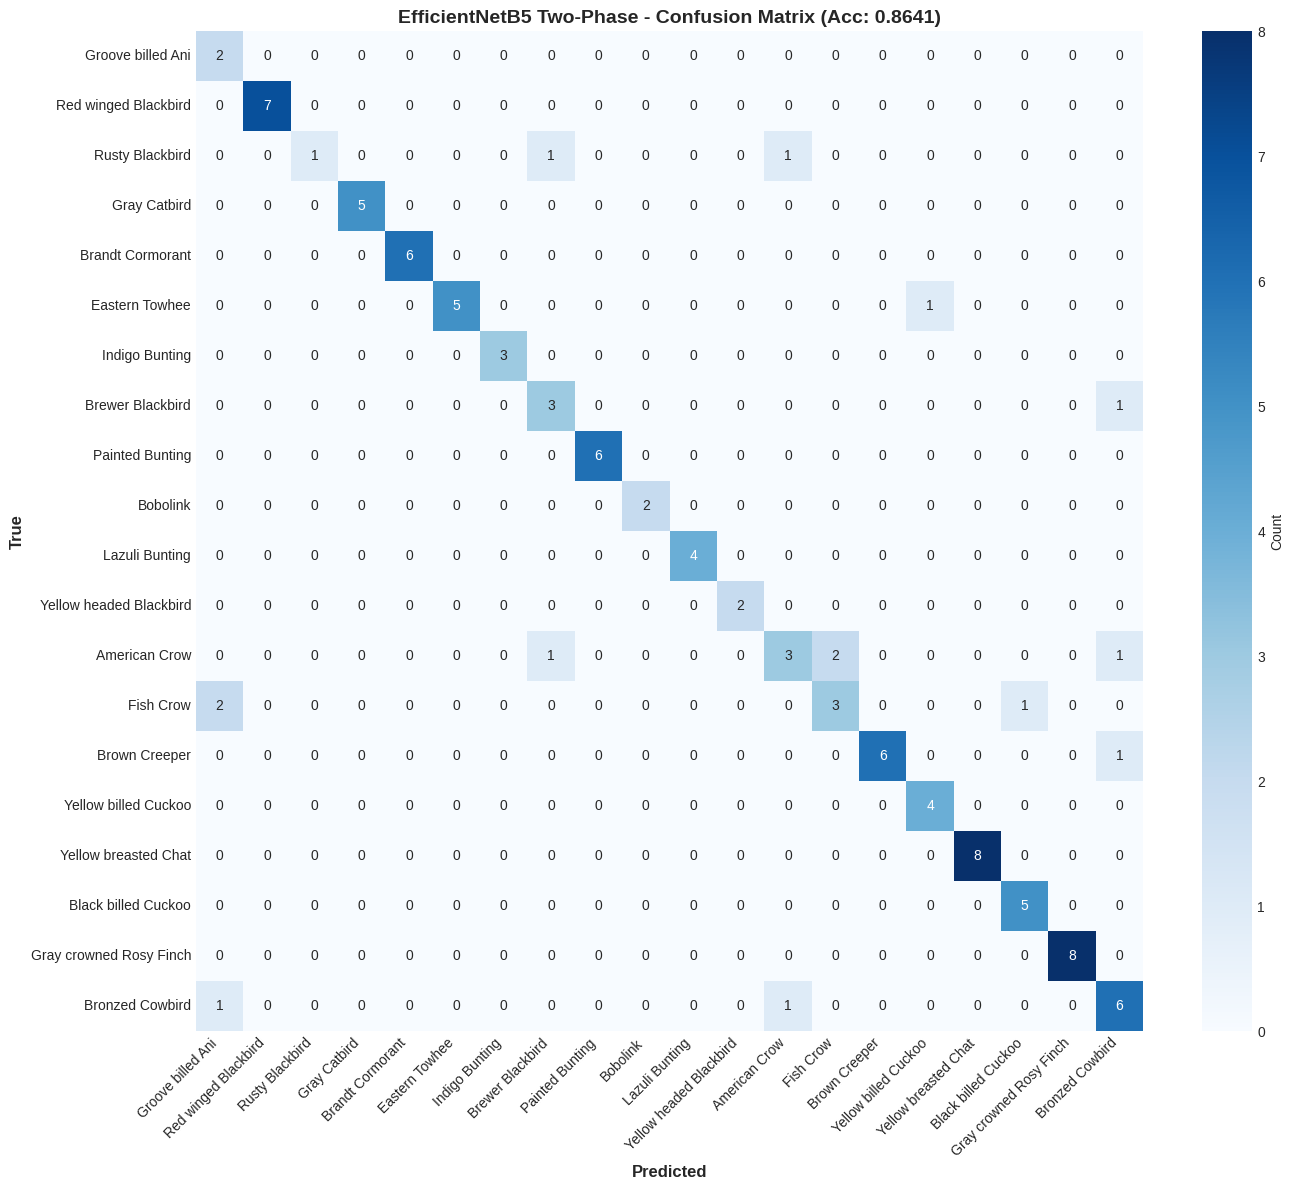

✓ Confusion matrix saved


In [ ]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[CLASS_NAMES[i].replace('_', ' ') for i in range(NUM_CLASSES)],
            yticklabels=[CLASS_NAMES[i].replace('_', ' ') for i in range(NUM_CLASSES)],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('True', fontsize=12, fontweight='bold')
plt.title(f'EfficientNetB5 Two-Phase - Confusion Matrix (Acc: {test_accuracy:.4f})',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG['results_dir'], 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print('✓ Confusion matrix saved')

In [ ]:
# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70 + "\n")

report = classification_report(
    all_labels,
    all_preds,
    target_names=[CLASS_NAMES[i].replace('_', ' ') for i in range(NUM_CLASSES)],
    digits=4
)
print(report)

# Save report
with open(os.path.join(CONFIG['results_dir'], 'classification_report.txt'), 'w') as f:
    f.write(report)


CLASSIFICATION REPORT

                         precision    recall  f1-score   support

      Groove billed Ani     0.4000    1.0000    0.5714         2
   Red winged Blackbird     1.0000    1.0000    1.0000         7
        Rusty Blackbird     1.0000    0.3333    0.5000         3
           Gray Catbird     1.0000    1.0000    1.0000         5
       Brandt Cormorant     1.0000    1.0000    1.0000         6
         Eastern Towhee     1.0000    0.8333    0.9091         6
         Indigo Bunting     1.0000    1.0000    1.0000         3
       Brewer Blackbird     0.6000    0.7500    0.6667         4
        Painted Bunting     1.0000    1.0000    1.0000         6
               Bobolink     1.0000    1.0000    1.0000         2
         Lazuli Bunting     1.0000    1.0000    1.0000         4
Yellow headed Blackbird     1.0000    1.0000    1.0000         2
          American Crow     0.6000    0.4286    0.5000         7
              Fish Crow     0.6000    0.5000    0.5455         6


## 8. Generate Test Predictions

In [ ]:
# Load test data
test_df = pd.read_csv(CONFIG['sample_submission'])

# Create test dataset
def load_test_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [CONFIG['img_size'], CONFIG['img_size']])
    img = preprocess_input(img)
    return img

test_paths = [os.path.join(CONFIG['test_images'], path) for path in test_df['path'].values]
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(CONFIG['batch_size'])
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Test images: {len(test_df)}")

Test images: 400


In [ ]:
# Generate predictions
print("\nGenerating test predictions...")

predictions = []
for batch in tqdm(test_dataset, desc="Predicting"):
    preds = model.predict(batch, verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    predictions.extend(pred_classes)

# Create submission
submission = pd.DataFrame({
    'path': test_df['path'],
    'class_idx': predictions
})

submission_path = os.path.join(CONFIG['results_dir'], 'submission_efficientnetb5_twophase.csv')
submission.to_csv(submission_path, index=False)

print(f"\n✓ Submission saved: {submission_path}")
print(f"Total predictions: {len(predictions)}")
print(f"\nPrediction distribution:")
print(pd.Series(predictions).value_counts().sort_index())


Generating test predictions...


Predicting:   0%|          | 0/13 [00:00<?, ?it/s]


✓ Submission saved: /content/drive/MyDrive/ml_results/phase3_efficientnetb5_results/submission_efficientnetb5_twophase.csv
Total predictions: 400

Prediction distribution:
0     24
1     14
2     18
3     23
4     24
5     18
6     13
7     16
8     16
9     23
10    18
11    17
12    25
13    15
14    26
15    24
16    22
17    29
18    20
19    15
Name: count, dtype: int64
